### IMPORTS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import FeatureUnion

### LOADING DATA

In [2]:
DATA = pd.read_csv("webpage data.csv")

In [3]:
DATA.head()

,Webpage_id,Domain,Url,Tag
0,1,www.fiercepharma.com,http://www.fiercepharma.com/marketing/tecfider...,news
1,2,www.fiercepharma.com,http://www.fiercepharma.com/pharma/novo-equipp...,news
2,3,www.fiercepharma.com,http://www.fiercepharma.com/pharma/another-exe...,news
3,4,www.fiercepharma.com,http://www.fiercepharma.com/pharma/teva-buy-bi...,news
4,5,www.fiercepharma.com,http://www.fiercepharma.com/marketing/actress-...,news


### EDA

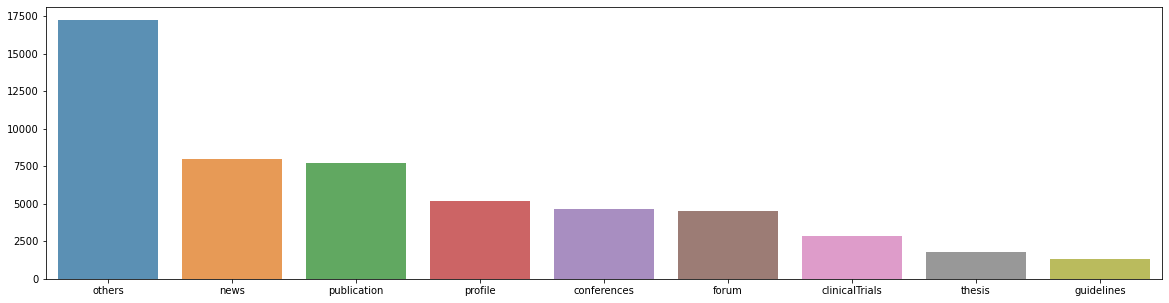

In [4]:
count = DATA['Tag'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(count.index, count.values, alpha=0.8)
plt.xticks()
plt.show()

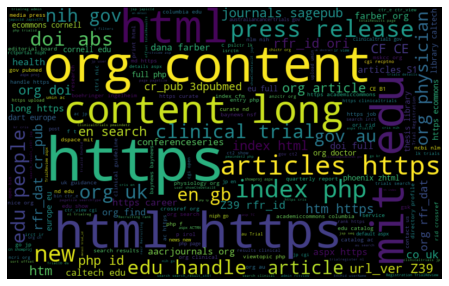

In [5]:
all_words = ' '.join([text for text in DATA['Url']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### FEATURE EXTRACTION

##### REMOVE UNNECESSARY CHARACTERS

In [6]:
DATA["Url"] = DATA["Url"].str.replace("/", " ")
DATA["Url"] = DATA["Url"].str.replace("-", " ")
DATA["Url"] = DATA["Url"].str.replace("https:", "")
DATA["Url"] = DATA["Url"].str.replace("http:", "")

##### ENCODE TARGER VARIABLE

In [7]:
TAG_DICT = {"others":1, "news": 2, "publication":3, "profile": 4, "conferences": 5, "forum": 6, "clinicalTrials": 7, "thesis": 8, "guidelines": 9}
DATA['target'] = DATA['Tag'].map(TAG_DICT)

##### A particular domian name can belong to different tags, hence to prevent the classifier for determining tag directly from domain name we are creating a new variable for splitting the data

In [8]:
DATA["target_str"] = DATA["Domain"].astype(str) + '_' + DATA["Tag"].astype(str)

In [9]:
DATA.head()

,Webpage_id,Domain,Url,Tag,target,target_str
0,1,www.fiercepharma.com,www.fiercepharma.com marketing tecfidera gil...,news,2,www.fiercepharma.com_news
1,2,www.fiercepharma.com,www.fiercepharma.com pharma novo equipped to...,news,2,www.fiercepharma.com_news
2,3,www.fiercepharma.com,www.fiercepharma.com pharma another exec dep...,news,2,www.fiercepharma.com_news
3,4,www.fiercepharma.com,www.fiercepharma.com pharma teva buy biosim ...,news,2,www.fiercepharma.com_news
4,5,www.fiercepharma.com,www.fiercepharma.com marketing actress maris...,news,2,www.fiercepharma.com_news


### MODEL

In [10]:
cvlist = list(GroupKFold(5).split(DATA, groups=DATA["target_str"]))

In [11]:
def cv_score(ml_model, url):
    i = 1
    
    for df_index,test_index in cvlist:
        
        xtr,xvl = url[df_index], url[test_index]
        ytr,yvl = DATA['target'][df_index], DATA['target'][test_index]
            
        model = ml_model
        model.fit(xtr, ytr)
        pred_probs = model.predict_proba(xvl)
        label_preds = np.argmax(pred_probs, axis=1) + 1
        
        score = f1_score(yvl, label_preds, average="weighted")
        print('\n{} of Group kfold {} Weighted F1 Score: {}'.format(i,5,score))
         
        i+=1

##### Naive Bayers

In [12]:
vec_bow = CountVectorizer(ngram_range=(1, 3), min_df=400)
vec_bow.fit(DATA['Url'])
Url_bow = vec_bow.transform(DATA['Url'])

In [13]:
cv_score(MultinomialNB(alpha=.01), Url_bow)


1 of Group kfold 5 Weighted F1 Score: 0.5956128341766787

2 of Group kfold 5 Weighted F1 Score: 0.633705111236572

3 of Group kfold 5 Weighted F1 Score: 0.5840241700440744

4 of Group kfold 5 Weighted F1 Score: 0.6726147439623907

5 of Group kfold 5 Weighted F1 Score: 0.685451579382621


##### Naive Bayers with both char and word ngrams

In [14]:
# Word and character BOW on URLs
vec1 = CountVectorizer(analyzer='char', ngram_range=(1, 5), min_df=500)
vec2 = CountVectorizer(analyzer='word', ngram_range=(1, 3), min_df=400)
vec_bow = FeatureUnion([("char", vec1), ("word", vec2)])
vec_bow.fit(DATA['Url'])
Url_bow = vec_bow.transform(DATA['Url'])

In [15]:
cv_score(MultinomialNB(alpha=.01), Url_bow)


1 of Group kfold 5 Weighted F1 Score: 0.6762799783456942

2 of Group kfold 5 Weighted F1 Score: 0.6850809337506776

3 of Group kfold 5 Weighted F1 Score: 0.688822967439938

4 of Group kfold 5 Weighted F1 Score: 0.7216948488261381

5 of Group kfold 5 Weighted F1 Score: 0.704485742627938


###### Naive Bayers with char and word ngram with TFIDF

In [16]:
# Word and character TFIDF on URLs
vec1 = TfidfVectorizer(analyzer='char', ngram_range=(1, 5), min_df=500)
vec2 = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=400)
vec_tfidf = FeatureUnion([("char", vec1), ("word", vec2)])
vec_tfidf.fit(DATA['Url'])
Url_tfidf = vec_tfidf.transform(DATA['Url'])

In [17]:
cv_score(MultinomialNB(alpha=.01), Url_tfidf)


1 of Group kfold 5 Weighted F1 Score: 0.709831531814438

2 of Group kfold 5 Weighted F1 Score: 0.7028857528401553

3 of Group kfold 5 Weighted F1 Score: 0.7140138082517805

4 of Group kfold 5 Weighted F1 Score: 0.7474394007453241

5 of Group kfold 5 Weighted F1 Score: 0.7294679427204096


##### Logistic Regression with char and word ngram with TFIDF

In [18]:
cv_score(LogisticRegression(C=0.1,class_weight="balanced"), Url_tfidf)


1 of Group kfold 5 Weighted F1 Score: 0.7001477047644526

2 of Group kfold 5 Weighted F1 Score: 0.7420657506101059

3 of Group kfold 5 Weighted F1 Score: 0.7467646471394166

4 of Group kfold 5 Weighted F1 Score: 0.7988550572649397

5 of Group kfold 5 Weighted F1 Score: 0.7921636915688668


##### Decision tree with char and word ngram with TFIDF

In [19]:
cv_score(DecisionTreeClassifier(min_samples_leaf=25, min_samples_split=25), Url_tfidf)


1 of Group kfold 5 Weighted F1 Score: 0.6013691321167933

2 of Group kfold 5 Weighted F1 Score: 0.6280923535505827

3 of Group kfold 5 Weighted F1 Score: 0.6229585140621545

4 of Group kfold 5 Weighted F1 Score: 0.6306789181983291

5 of Group kfold 5 Weighted F1 Score: 0.6519695957380417


##### Random forest with char and word ngram with TFIDF

In [20]:
rf_params = {'random_state': 0, 'n_jobs': -1, 'n_estimators': 100, 'max_depth': 50, 'n_jobs': -1}
cv_score(RandomForestClassifier(**rf_params), Url_tfidf)


1 of Group kfold 5 Weighted F1 Score: 0.6606028719369305

2 of Group kfold 5 Weighted F1 Score: 0.6788263035907093

3 of Group kfold 5 Weighted F1 Score: 0.6459859779651346

4 of Group kfold 5 Weighted F1 Score: 0.7276128735459069

5 of Group kfold 5 Weighted F1 Score: 0.7319454872882054
